In [4]:
import os 
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root) 

from src.model_utils import trainModel,tuneModel, save_params_to_json,saveModel
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from src.eval_metric import Metric
from src.preprocessor_utils import split_data
from src.pipeline_imbalanced import smote_pipeline, smote_under_pipeline


In [5]:
import nltk

# Tải gói 'popular' bao gồm: punkt, stopwords, wordnet, averaged_perceptron_tagger, v.v.
nltk.download('popular', quiet=True)

# Tải gói punkt_tab (bắt buộc cho các phiên bản NLTK mới, thường bị bỏ qua bởi gói popular)
nltk.download('punkt_tab', quiet=True)


True

In [6]:
path_train = 'D:\PythonLearn\workspace\Test\KPDL_1\data\data_train.csv'
path_test = 'D:\PythonLearn\workspace\Test\KPDL_1\data\data_test.csv'


In [7]:
d_train = pd.read_csv(path_train)
d_test = pd.read_csv(path_test)
    

# COUNT DATA

In [8]:
import joblib
x = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_count_data.pkl'
preprocess = joblib.load(x)
X_train = preprocess[0]
Y_train = preprocess[1]

In [9]:
cont_pipeline = 'D:\\PythonLearn\\workspace\\Test\\KPDL_1\\models\\Preprocess_count_pipeline.pkl'
preprocess_2 = joblib.load(cont_pipeline)

In [10]:
X_test, Y_test = split_data(d_test)

In [12]:
x_test = preprocess_2.transform(X_test)


In [13]:
model = trainModel(X_train, Y_train, model_name='rf')


Training RF......
Train successful


In [14]:
eval_model=Metric(model, x_test, Y_test)

--- ĐÁNH GIÁ: RF (Threshold=0.25) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.81      0.88       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9879
PR-AUC (AUPRC): 0.9408 (Quan trọng cho Fraud)


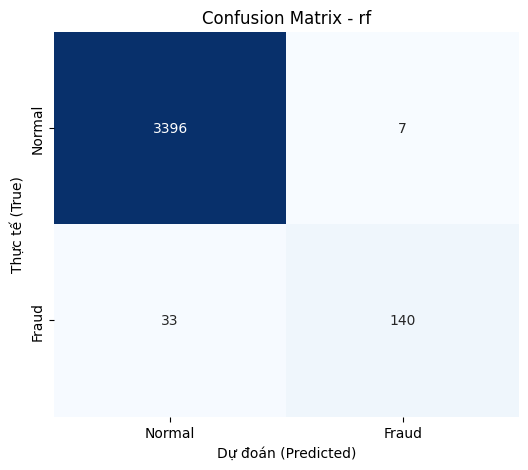

In [15]:
eval_model.evaluate_model('rf', 0.25)


In [16]:
param_rcv = {
    "n_estimators": [200,300,500],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [5, 8, 10],
    "min_samples_leaf": [2, 4, 8],
    "max_depth": [10, 20, 30]
}

In [17]:
model_tuned = tuneModel(X_train, Y_train, model_name='rf', raw_params=param_rcv,name_search="rcv",n_iter = 50)

---------Starting Tuning RF-------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
=======result tune============
Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy'}
Best f1: 0.6069


In [18]:
param_gcv = {
    "n_estimators": [300],
    "max_features": ["sqrt"],
    "criterion": ["entropy"],
    "min_samples_split": [3, 5, 7],
    "min_samples_leaf": [2, 4, 8],
    "max_depth": [20, 30, 35]
}

In [24]:
model_tuned_contdata = tuneModel(X_train, Y_train, model_name='rf', raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
Best f1: 0.6273


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.65      0.79       173

    accuracy                           0.98      3576
   macro avg       0.99      0.82      0.89      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9944
PR-AUC (AUPRC): 0.9522 (Quan trọng cho Fraud)


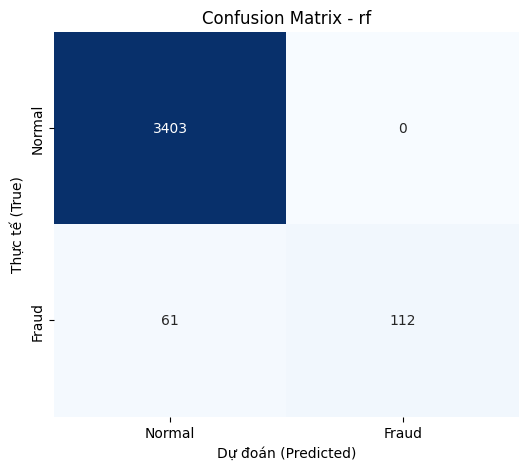

In [25]:
eval_model = Metric(model_tuned[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.35)

In [27]:
save_params_to_json(model_tuned[1], r"D:\PythonLearn\workspace\Test\KPDL_1\configs\rf_gcv_params_model_tuned_countdata.json")
saveModel(model_tuned[0], r"D:\PythonLearn\workspace\Test\KPDL_1\models\rf_gcv_model_tuned_countdata.pkl")

 Đã lưu params vào: D:\PythonLearn\workspace\Test\KPDL_1\configs\rf_gcv_params_model_tuned_countdata.json


'DONE'

In [ ]:
X_smote, Y_smote = smote_pipeline(X_train, Y_train)
model_smote = tuneModel(X_smote, Y_smote, model_name='rf',raw_params=param_gcv,name_search="gcv")


---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best f1: 0.9936


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3403
           1       0.05      1.00      0.09       173

    accuracy                           0.05      3576
   macro avg       0.52      0.50      0.05      3576
weighted avg       0.95      0.05      0.01      3576

ROC-AUC: 0.8556
PR-AUC (AUPRC): 0.3586 (Quan trọng cho Fraud)


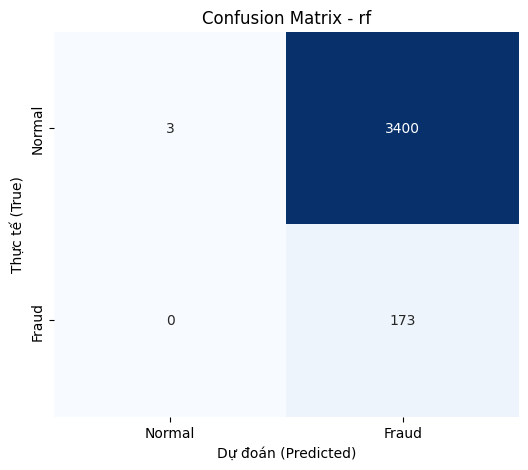

In [ ]:
eval_model = Metric(model_smote[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.35)

In [ ]:
X_smote, Y_smote = smote_under_pipeline(X_train, Y_train)
model_smote_under = tuneModel(X_smote, Y_smote, model_name='rf',raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best f1: 0.9628


--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.85      0.73      0.79       173

    accuracy                           0.98      3576
   macro avg       0.92      0.86      0.89      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9896
PR-AUC (AUPRC): 0.8795 (Quan trọng cho Fraud)


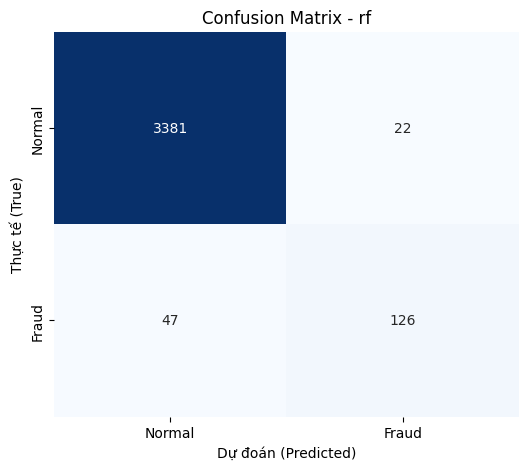

In [ ]:
eval_model = Metric(model_smote_under[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.5)

# TFIDF

In [28]:
y = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_tfidf_data.pkl'
preprocess = joblib.load(y)
X_train_tfidf = preprocess[0]
Y_train = preprocess[1]

In [29]:
tfidf_pipeline = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_tfidf_pipeline.pkl'
preprocess_2 = joblib.load(tfidf_pipeline)

In [30]:
x_test = preprocess_2.transform(X_test)
model = trainModel(X_train_tfidf, Y_train, model_name='rf')

Training RF......
Train successful


--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.61      0.76       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9946
PR-AUC (AUPRC): 0.9415 (Quan trọng cho Fraud)


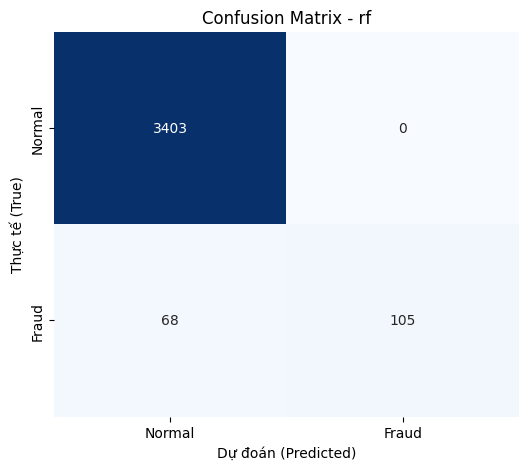

In [31]:
eval_model=Metric(model, x_test, Y_test)
eval_model.evaluate_model('rf', 0.5)

In [32]:
param_rcv = {
    "n_estimators": [200,300,500],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [5, 8, 10],
    "min_samples_leaf": [2, 4, 8],
    "max_depth": [10, 20, 30]
}

In [34]:
model_tuned = tuneModel(X_train_tfidf, Y_train, model_name='rf', raw_params=param_rcv,name_search="rcv",n_iter = 50)

---------Starting Tuning RF-------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
=======result tune============
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy'}
Best f1: 0.5562


In [35]:
param_gcv = {
    "n_estimators": [200],
    "max_features": ["sqrt"],
    "criterion": ["entropy"],
    "min_samples_split": [3, 5, 7],
    "min_samples_leaf": [2, 4, 6],
    "max_depth": [20, 30, 35]
}

In [36]:
model_tuned = tuneModel(X_train_tfidf, Y_train, model_name='rf', raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best f1: 0.6180


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.61      0.76       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9940
PR-AUC (AUPRC): 0.9424 (Quan trọng cho Fraud)


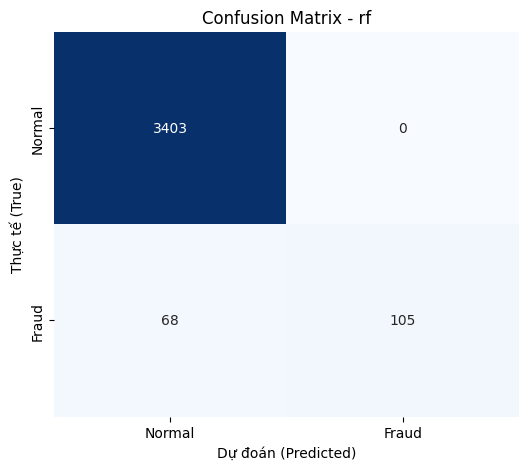

In [37]:
eval_model = Metric(model_tuned[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.35)

In [38]:
save_params_to_json(model_tuned[1], r"D:\PythonLearn\workspace\Test\KPDL_1\configs\rf_gcv_params_model_tuned_tfidf.json")
saveModel(model_tuned[0], r"D:\PythonLearn\workspace\Test\KPDL_1\models\rf_gcv_model_tuned_tfidf.pkl")

 Đã lưu params vào: D:\PythonLearn\workspace\Test\KPDL_1\configs\rf_gcv_params_model_tuned_tfidf.json


'DONE'

In [ ]:
X_smote, Y_smote = smote_pipeline(X_train_tfidf, Y_train)
model_smote_tfidf = tuneModel(X_smote, Y_smote, model_name='rf',raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best f1: 0.9983


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.88      0.83      0.85       173

    accuracy                           0.99      3576
   macro avg       0.93      0.91      0.92      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9919
PR-AUC (AUPRC): 0.9246 (Quan trọng cho Fraud)


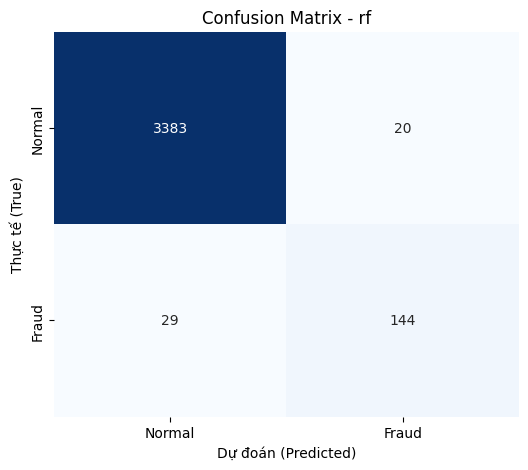

In [ ]:
eval_model = Metric(model_smote_tfidf[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.35)

In [ ]:
X_smote, Y_smote = smote_under_pipeline(X_train_tfidf, Y_train)
model_smote_under_tfidf = tuneModel(X_smote, Y_smote, model_name='rf',raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
Best f1: 0.9816


--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.89      0.81      0.85       173

    accuracy                           0.99      3576
   macro avg       0.94      0.90      0.92      3576
weighted avg       0.99      0.99      0.99      3576

ROC-AUC: 0.9895
PR-AUC (AUPRC): 0.9078 (Quan trọng cho Fraud)


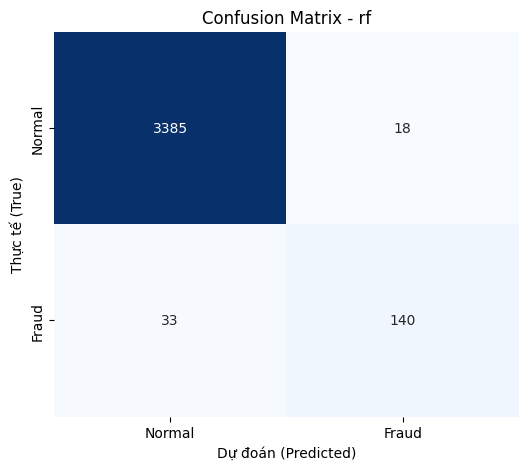

In [ ]:
eval_model = Metric(model_smote_under_tfidf[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.5)

# word2vec

In [39]:
z = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_word2vec_data.pkl'
preprocess = joblib.load(z)
X_train_w2v = preprocess[0]
Y_train = preprocess[1]

In [40]:
word2vec_pipeline = 'D:\PythonLearn\workspace\Test\KPDL_1\models\Preprocess_word2vec_pipeline.pkl'
preprocess_2 = joblib.load(word2vec_pipeline)

In [41]:
x_test = preprocess_2.transform(X_test)
model = trainModel(X_train_w2v, Y_train, model_name='rf')

Training RF......
Train successful


--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       0.99      0.42      0.59       173

    accuracy                           0.97      3576
   macro avg       0.98      0.71      0.79      3576
weighted avg       0.97      0.97      0.97      3576

ROC-AUC: 0.9699
PR-AUC (AUPRC): 0.8110 (Quan trọng cho Fraud)


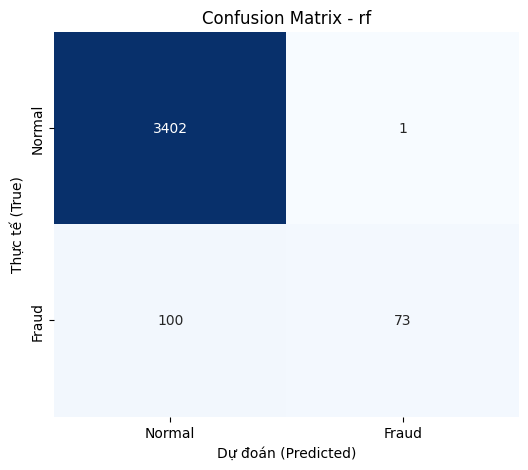

In [42]:
eval_model=Metric(model, x_test, Y_test)
eval_model.evaluate_model('rf', 0.5)

In [43]:
param_rcv = {
    "n_estimators": [200,300,500],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [5, 8, 10],
    "min_samples_leaf": [2, 4, 8],
    "max_depth": [10, 20, 30]
}

In [ ]:
model_tuned_w2v = tuneModel(X_train_w2v, Y_train, model_name='rf', raw_params=param_rcv,name_search="rcv",n_iter = 50)

---------Starting Tuning RF-------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
=======result tune============
Best params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}
Best f1: 0.5772


In [44]:
param_gcv = {
    "n_estimators": [500],
    "max_features": ["sqrt"],
    "criterion": ["entropy"],
    "min_samples_split": [8, 10, 12],
    "min_samples_leaf": [2, 4, 6],
    "max_depth": [15, 20, 25]
}

In [ ]:
model_tuned_w2v = tuneModel(X_train_w2v, Y_train, model_name='rf', raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}
Best f1: 0.5775


--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3403
           1       0.99      0.40      0.57       173

    accuracy                           0.97      3576
   macro avg       0.98      0.70      0.78      3576
weighted avg       0.97      0.97      0.97      3576

ROC-AUC: 0.9793
PR-AUC (AUPRC): 0.8480 (Quan trọng cho Fraud)


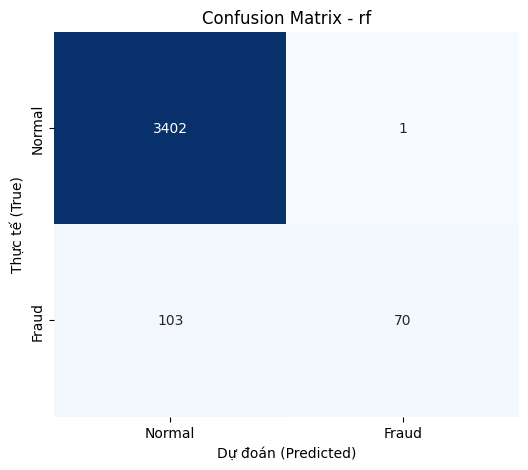

In [ ]:
eval_model = Metric(model_tuned_w2v[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.5)

In [45]:
X_smote, Y_smote = smote_pipeline(X_train_w2v, Y_train)
model_smote_w2v = tuneModel(X_smote, Y_smote, model_name='rf',raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}
Best f1: 0.9949


--- ĐÁNH GIÁ: RF (Threshold=0.35) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.68      0.83      0.75       173

    accuracy                           0.97      3576
   macro avg       0.84      0.91      0.87      3576
weighted avg       0.98      0.97      0.97      3576

ROC-AUC: 0.9789
PR-AUC (AUPRC): 0.8619 (Quan trọng cho Fraud)


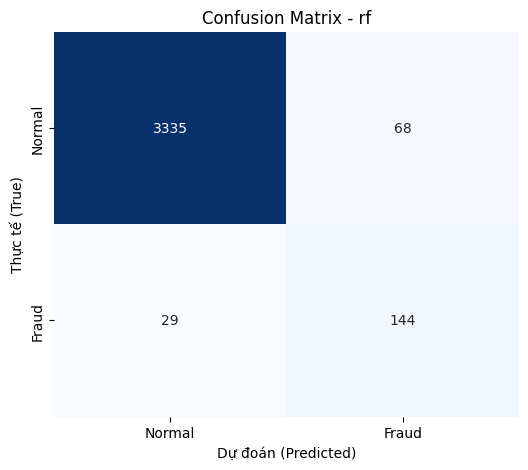

In [46]:
eval_model = Metric(model_smote_w2v[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.35)

In [48]:
save_params_to_json(model_smote_w2v[1], r"D:\PythonLearn\workspace\Test\KPDL_1\configs\rf_gcv_params_model_tuned_w2v.json")
saveModel(model_smote_w2v[0], r"D:\PythonLearn\workspace\Test\KPDL_1\models\rf_gcv_model_tuned_w2v.pkl")

 Đã lưu params vào: D:\PythonLearn\workspace\Test\KPDL_1\configs\rf_gcv_params_model_tuned_w2v.json


'DONE'

In [ ]:
X_smote, Y_smote = smote_under_pipeline(X_train_w2v, Y_train)
model_smote_under_w2v = tuneModel(X_smote, Y_smote, model_name='rf',raw_params=param_gcv,name_search="gcv")

---------Starting Tuning RF-------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
=======result tune============
Best params: {'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}
Best f1: 0.9716


--- ĐÁNH GIÁ: RF (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3403
           1       0.66      0.80      0.73       173

    accuracy                           0.97      3576
   macro avg       0.83      0.89      0.86      3576
weighted avg       0.97      0.97      0.97      3576

ROC-AUC: 0.9739
PR-AUC (AUPRC): 0.8258 (Quan trọng cho Fraud)


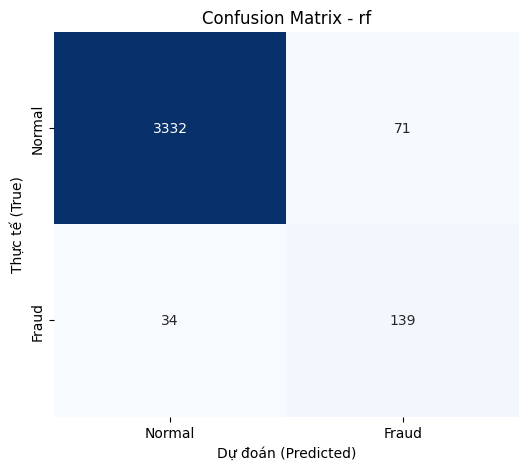

In [ ]:
eval_model = Metric(model_smote_under_w2v[0], x_test, Y_test)
eval_model.evaluate_model('rf', 0.5)